In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Plot_tools import *

from scipy.ndimage import label, generate_binary_structure, binary_dilation

# define a grid to interpolation profiles to

zhgts = 250. + 250.*np.arange(60)

_nthreads = 2

#---------------------------------------------------------------------

def interp3d_np(data, z3d, z1d, nthreads = _nthreads):
    
    dinterp = np.zeros((len(z1d),data.shape[1]),dtype=np.float32)

    if nthreads < 0:  # turning this off for now.
        def worker(j):
            print("running %d %s" % (i, data.shape))
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        pool = mp.Pool(nthreads)
        for i in np.arange(data.shape[2]):
            pool.apply_async(worker, args = (i, ))
        pool.close()
        pool.join()
        
        return dinterp
    
    else:        
        for j in np.arange(data.shape[1]):
            dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

        return dinterp



In [25]:
def generate_ideal_profiles(run_dir, model_type='wrf', w_thresh = 5.0, cref_thresh = 45., min_pix=5):
    
    print(w_thresh, cref_thresh, min_pix)
    
    if model_type == 'wrf':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['Time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,  "wrfout*")

        w    = ds.W.values
        w    = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:])

        dbz  = ds.REFL_10CM.values
        pres = ds.P.values
        z    = ds.PHB.values/9.806
        z    = 0.5*(z[:,1:,:,:] + z[:,:-1,:,:])

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = 5.0, cref_thresh = 45., min_pix=5)
        
        ds.close()

        return profiles
    
    if model_type == 'fv3':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,   "*.nc")

        w    = ds.W.values
        w    = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:])
        dbz  = ds.REFL_10CM.values
        pres = ds.P.values
        z    = ds.PHB.values/9.806
        z    = 0.5*(z[:,1:,:,:] + z[:,:-1,:,:])

        profiles = compute_obj_profiles(w, dbz, pres, z, w_thresh = 5.0, cref_thresh = 45., min_pix=5)
        
        ds.close()

        return profiles
    
    if model_type == 'cm1':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, parallel=True)
    
        ds = open_mfdataset_list(run_dir,  "cm1out_0000*.nc")

        w    = ds.winterp.values
        dbz  = ds.dbz.values
        pres = ds.prs.values
        z    = ds.zh.values * 1000. # heights are in km
        # z3d  = np.tile(z[np.newaxis, :, np.newaxis, np.newaxis], (w.shape[0],1,w.shape[2],w.shape[3]))
        z3d  = np.broadcast_to(z[np.newaxis, :, np.newaxis, np.newaxis], w.shape)

        profiles = compute_obj_profiles(w, dbz, pres, z3d, w_thresh = 5.0, cref_thresh = 45., min_pix=5)
        
        ds.close()

        return profiles

#-------------------------------------------------------------------------------
def compute_obj_profiles(W, DBZ, PRES, Z, w_thresh = 5.0, cref_thresh = 45., min_pix=5):
           
    cref = DBZ.max(axis=1)
    
    mask_cref = np.where(cref >= cref_thresh, True, False)
    
    print('CREF: ', np.sum(mask_cref))

    mask_p = np.where(PRES <= 70000., True, False)
    
    print('P-MASK: ', np.sum(mask_p))

    mask_w = np.where(W > w_thresh, True, False)
    
    print('W-MASK: ', np.sum(mask_w))

    mask_w_p = mask_p & mask_w
    
    print('W-P-MASK: ', np.sum(mask_w_p))

    mask_w_p_2d = np.any(mask_w_p, axis=1) & mask_cref
    
    f_mask = np.array(np.where(mask_w_p_2d, 1, 0), dtype=np.int8)
    
    print('F-MASK: ',np.sum(f_mask))
    
    # this code looks for a 3x3 connected region of True (1) values.
    
    connectivity = np.ones((3,) * 2)  # 3x3 matric of ones

    wlist = [] 
    all_obj = 0
    w_obj   = 0
    
    for n in np.arange(W.shape[0]): # loop over number of time steps.
        
        labeled_array = label(f_mask[n], connectivity)[0]        # returns a 2D array of labels for updrafts)
    
        num_obj = np.unique(labeled_array)                       # find the number of unique objects (background will be one obj)
        
        all_obj += (num_obj.shape[0]-1)
        
        if( num_obj.shape[0] > 1 ):                              # if there is more than the background object, process array.

            for l in num_obj[1:]:                                # this is just a list of 1,2,3,4.....23,24,25....
                npix = np.sum(labeled_array == l+1)              # this is a size check - number of pixels assocated with a label
                if npix >= min_pix:
                    jloc, iloc = np.where(labeled_array == l+1)  # extract out the locations of the updrafts 
                    w_obj += 1
                    if len(iloc) > 0:
                        wraw    = W[n,:,jloc,iloc]               # get w_raw profiles
                        zraw    = Z[n,:,jloc,iloc]               # get z_raw profiles
                        
                        profile = interp3d_np(wraw.transpose(), zraw.transpose(), zhgts, nthreads = _nthreads)
                        
                        wlist.append([profile.mean(axis=1)],)  

    wprofile = np.squeeze(np.asarray(wlist), axis=1).transpose()

    print("\n Number of selected updraft profiles:  %d \n Number of labeled objects:  %d\n" % (w_obj, all_obj))
    
    return wprofile

In [26]:
w_thresh = 1.
cref_thresh = 10.
min_pix = 1

# CM1

input_dir  = '/scratch/wicker/cm1r20.3/run'
output_dir = './'

cm1_q14 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_q14_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q11 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q11_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q12 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q12_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q13 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q13_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q15 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q15_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q16 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q16_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)

# WRF ######

in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf3_dir      = str(os.path.join(in_dir, "WRF_km4_dt15", shear))
wrf3_wprofile = generate_ideal_profiles(str(os.path.join(wrf3_dir)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)


# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

fv3A_dir     = str(os.path.join(in_dir, "FV3_dt20_hord6_q14", shear))
fv3_wprofile = generate_ideal_profiles(str(os.path.join(fv3A_dir)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)


1.0 10.0 1
CREF:  4337
P-MASK:  63897600
W-MASK:  35538
W-P-MASK:  32594
F-MASK:  2002

 Number of selected updraft profiles:  139 
 Number of labeled objects:  263

1.0 10.0 1
CREF:  16597
P-MASK:  92798976
W-MASK:  111522
W-P-MASK:  111522
F-MASK:  6903

 Number of selected updraft profiles:  368 
 Number of labeled objects:  1087

1.0 10.0 1
CREF:  14013
P-MASK:  94371840
W-MASK:  118943
W-P-MASK:  118943
F-MASK:  6125

 Number of selected updraft profiles:  427 
 Number of labeled objects:  636



In [27]:
w_thresh = 10.
cref_thresh = 55.
min_pix = 1

# CM1

input_dir  = '/scratch/wicker/cm1r20.3/run'
output_dir = './'

cm1_q14 = generate_ideal_profiles(str(os.path.join(input_dir, 'squall_q14_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q11 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q11_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q12 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q12_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q13 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q13_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q15 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q15_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)
# cm1_q16 = generate_model_profiles(str(os.path.join(input_dir, 'squall_q16_s12')), model_type='cm1', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)

# WRF ######

in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

wrf3_dir      = str(os.path.join(in_dir, "WRF_km4_dt15", shear))
wrf3_wprofile = generate_ideal_profiles(str(os.path.join(wrf3_dir)), model_type='wrf', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)


# FV3 #######
in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = "/work/wicker/CAM_analysis_tools"
shear   = "shallow_12.5"

fv3A_dir     = str(os.path.join(in_dir, "FV3_dt20_hord6_q14", shear))
fv3_wprofile = generate_ideal_profiles(str(os.path.join(fv3A_dir)), model_type='fv3', w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix)

10.0 55.0 1
CREF:  4337
P-MASK:  63897600
W-MASK:  35538
W-P-MASK:  32594
F-MASK:  2002

 Number of selected updraft profiles:  139 
 Number of labeled objects:  263

10.0 55.0 1
CREF:  16597
P-MASK:  92798976
W-MASK:  111522
W-P-MASK:  111522
F-MASK:  6903

 Number of selected updraft profiles:  368 
 Number of labeled objects:  1087

10.0 55.0 1
CREF:  14013
P-MASK:  94371840
W-MASK:  118943
W-P-MASK:  118943
F-MASK:  6125

 Number of selected updraft profiles:  427 
 Number of labeled objects:  636



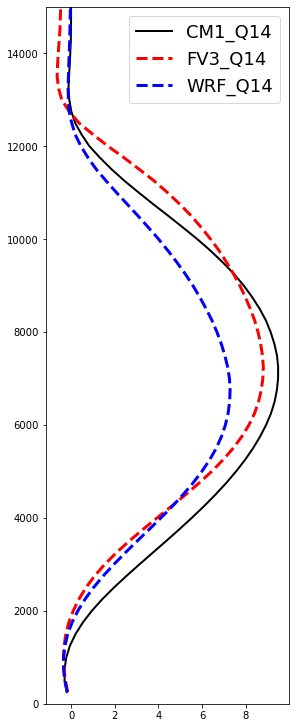

In [15]:
fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(4,10))

ax.plot(cm1_q14.mean(axis=1), zhgts, color='k', linewidth=2., label='CM1_Q14')

ax.plot(fv3_wprofile.mean(axis=1), zhgts, color='r', linewidth=3., linestyle='--', label='FV3_Q14')
ax.plot(wrf3_wprofile.mean(axis=1), zhgts, color='b', linewidth=3., linestyle='--', label='WRF_Q14')
ax.set_ylim(0.0,15000.)
ax.legend(fontsize=18)
plt.show()

NameError: name 'wprofile_q14' is not defined

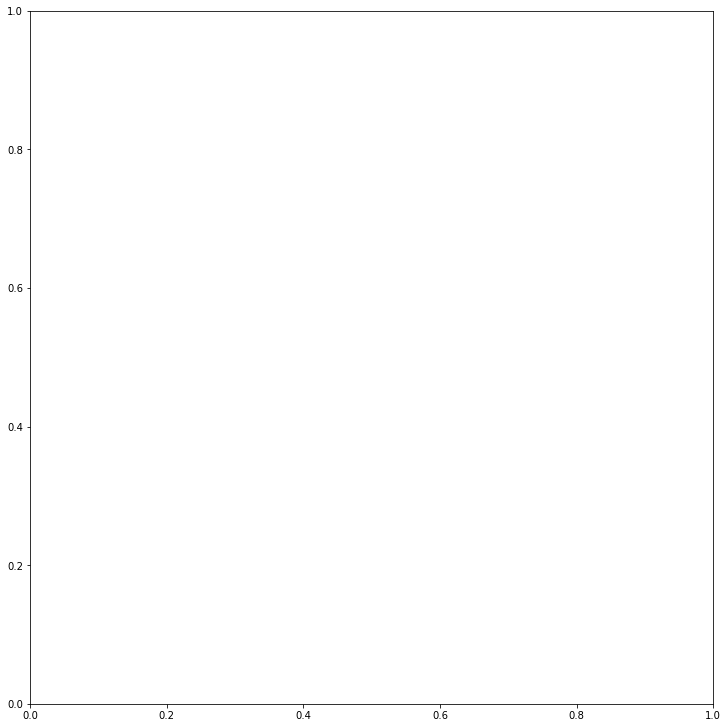

In [7]:
fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(10,10))

ax.plot(cm1_q14.mean(axis=1), zh_q14, color='k', linewidth=2.)

# ax.plot(wprofile_q11.mean(axis=1), zh_q14, color='y')
# ax.plot(wprofile_q12.mean(axis=1), zh_q14, color='orange')
# ax.plot(wprofile_q13.mean(axis=1), zh_q14, color='g')
# ax.plot(wprofile_q15.mean(axis=1), zh_q14, color='b')
# ax.plot(wprofile_q16.mean(axis=1), zh_q14, color='cyan')

ax.plot(fv3_wprofile.mean(axis=1), fv3_z, color='r', linewidth=3., linestyle='--' )
ax.plot(wrf3_wprofile.mean(axis=1), wrf_z, color='b', linewidth=3., linestyle='--' )
ax.set_ylim(0.0,15000.)
